# iNaturalist 2019 EDA + DL

Kudos and main ideas / reference: 

- [hsinwenchang/keras-data-augmentation-visualize](https://www.kaggle.com/hsinwenchang/keras-data-augmentation-visualize/notebook)
- [ateplyuk/inat2019-starter-keras-efficientnet](https://www.kaggle.com/ateplyuk/inat2019-starter-keras-efficientnet)

![](https://www.bahai.org/chrome/img/beliefs/nature-feature-img.jpg?f0550045)

[image-source](https://www.bahai.org/chrome/img/beliefs/nature-feature-img.jpg?f0550045)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

['train2019.json', 'train_val2019', 'val2019.json', 'test2019', 'kaggle_sample_submission.csv', 'test2019.json']


Using TensorFlow backend.


### Train data

In [2]:
ann_file = '../input/train2019.json'
with open(ann_file) as data_file:
        train_anns = json.load(data_file)

In [3]:
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [4]:
df_train_file_cat.shape

(265213, 3)

In [5]:
len(df_train_file_cat['category_id'].unique())

1010

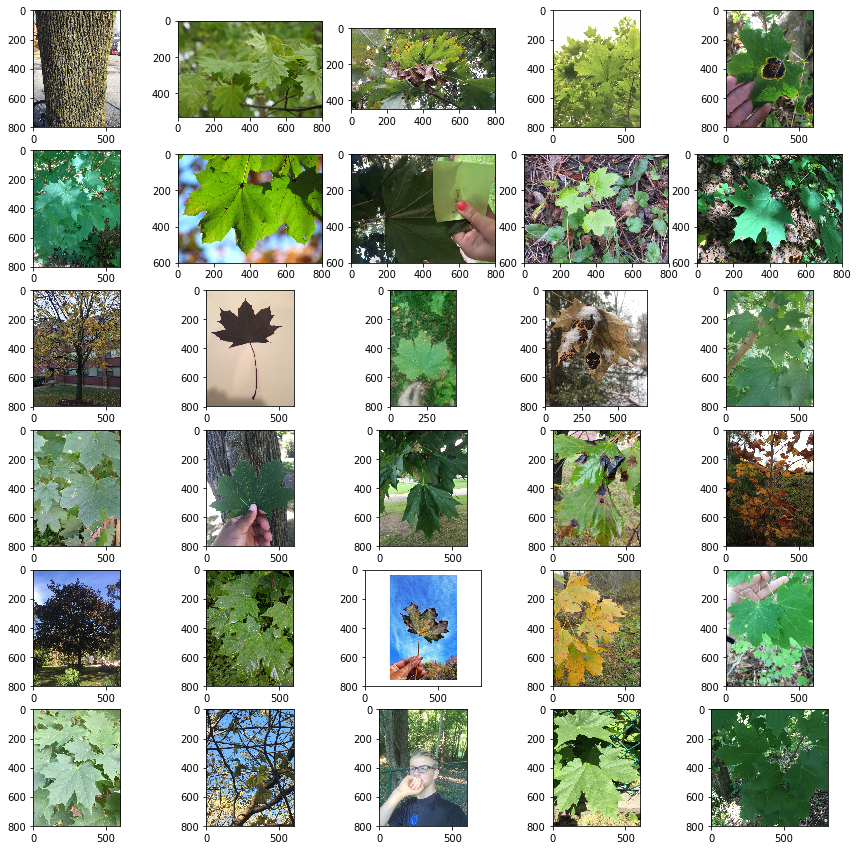

In [6]:
# Example of images for category_id = 400
img_names = df_train_file_cat[df_train_file_cat['category_id']=='400']['file_name'][:30]

plt.figure(figsize=[15,15])
i = 1
for img_name in img_names:
    img = cv2.imread("../input/train_val2019/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

### Validation data

In [7]:
valid_ann_file = '../input/val2019.json'
with open(valid_ann_file) as data_file:
        valid_anns = json.load(data_file)

In [8]:
valid_anns_df = pd.DataFrame(valid_anns['annotations'])[['image_id','category_id']]
valid_anns_df.head()

,image_id,category_id
0,265213,644
1,265214,597
2,265215,883
3,265216,300
4,265217,881


In [9]:
valid_img_df = pd.DataFrame(valid_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
valid_img_df.head()

,image_id,file_name
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...


In [10]:
df_valid_file_cat = pd.merge(valid_img_df, valid_anns_df, on='image_id')
df_valid_file_cat['category_id']=df_valid_file_cat['category_id'].astype(str)
df_valid_file_cat.head()

,image_id,file_name,category_id
0,265213,train_val2019/Plants/644/716a69838526f3ada3b2f...,644
1,265214,train_val2019/Plants/597/0942cc64d2e759c5ee059...,597
2,265215,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,883
3,265216,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,300
4,265217,train_val2019/Plants/881/76acaf0b2841f91982d21...,881


In [11]:
nb_classes = 1010
batch_size = 128
img_size = 128
nb_epochs = 40

### Oversampling

In [12]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(df_train_file_cat[["image_id", "file_name"]], df_train_file_cat["category_id"])

#train_df = pd.DataFrame(X_resampled, columns=["image_id", "file_name"])
#train_df["category_id"] = y_resampled

In [14]:
%%time
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train_file_cat,
    directory="../input/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 265213 images belonging to 1010 classes.
CPU times: user 5.48 s, sys: 8.73 s, total: 14.2 s
Wall time: 2min 9s


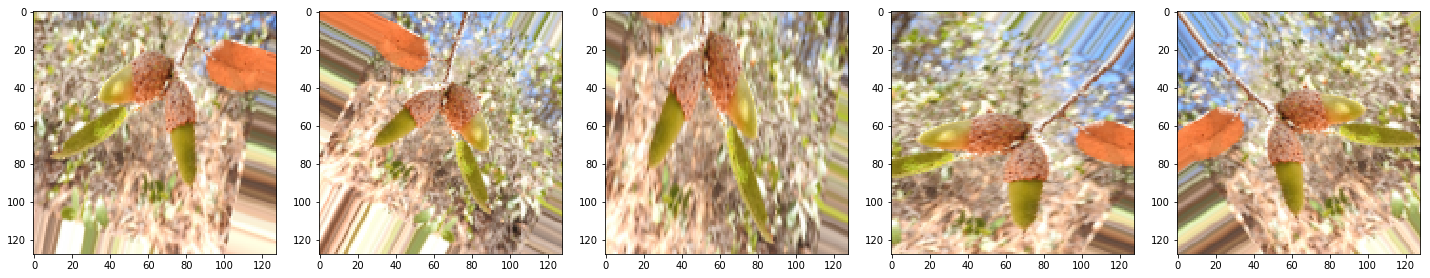

In [15]:
# udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb#scrollTo=jqb9OGoVKIOi
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [16]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(    
    dataframe=df_valid_file_cat,    
    directory="../input/train_val2019",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 3030 images belonging to 1010 classes.
CPU times: user 92 ms, sys: 84 ms, total: 176 ms
Wall time: 1.34 s


In [17]:
import gc
gc.collect();

### Model

In [24]:
#from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.nasnet import NASNetLarge
#from keras.applications.densenet import DenseNet121

#model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
model_name = "InceptionResNetV2"

219062272/219055592 [==============================] - 8s 0us/step


In [29]:
#Adding custom layers 
model_final = Sequential()
model_final.add(model)
model_final.add(Flatten())
model_final.add(Dense(1024, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(nb_classes, activation='softmax'))

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
#Callbacks

checkpoint = ModelCheckpoint(model_name, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [31]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              6292480   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1010)              1035250   
Total params: 61,664,466
Trainable params: 61,603,922
Non-trainable params: 60,544
_________________________________________________________________


In [34]:
%%time
history = model_final.fit_generator(generator=train_generator, 
                    steps_per_epoch=80,
                    validation_data=valid_generator,
                    validation_steps=40,
                    epochs=nb_epochs,
                    callbacks = [checkpoint, early],                
                    verbose=1)

Epoch 1/10
40/40 [==============================] - 147s 4s/step - loss: 6.7586 - acc: 0.0055 - val_loss: 6.9938 - val_acc: 0.0032
Epoch 2/10
40/40 [==============================] - 128s 3s/step - loss: 6.6714 - acc: 0.0066 - val_loss: 6.9140 - val_acc: 0.0111
Epoch 3/10
40/40 [==============================] - 129s 3s/step - loss: 6.5693 - acc: 0.0141 - val_loss: 6.8729 - val_acc: 0.0103
Epoch 4/10
40/40 [==============================] - 126s 3s/step - loss: 6.4162 - acc: 0.0211 - val_loss: 6.7804 - val_acc: 0.0151
Epoch 5/10
40/40 [==============================] - 127s 3s/step - loss: 6.2444 - acc: 0.0275 - val_loss: 6.7084 - val_acc: 0.0218
Epoch 6/10
40/40 [==============================] - 129s 3s/step - loss: 6.1215 - acc: 0.0285 - val_loss: 6.5907 - val_acc: 0.0234
Epoch 7/10
40/40 [==============================] - 126s 3s/step - loss: 5.9296 - acc: 0.0354 - val_loss: 6.4690 - val_acc: 0.0278
Epoch 8/10
40/40 [==============================] - 129s 3s/step - loss: 5.7741 - a

In [35]:
import gc
gc.collect();

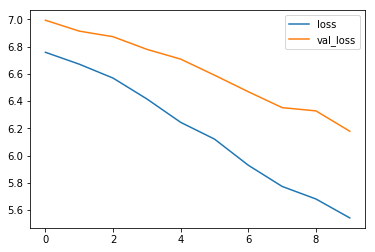

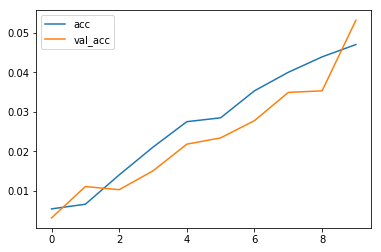

In [36]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [37]:
test_ann_file = '../input/test2019.json'
with open(test_ann_file) as data_file:
        test_anns = json.load(data_file)

In [38]:
test_img_df = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
test_img_df.head()

,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


In [39]:
%%time

test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=test_img_df,    
    
        directory = "../input/test2019",    
        x_col="file_name",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 35350 images.
CPU times: user 968 ms, sys: 784 ms, total: 1.75 s
Wall time: 14.3 s


### Prediction

In [40]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames), verbose=1)

35350/35350 [==============================] - 2853s 81ms/step
CPU times: user 1h 25s, sys: 1min 26s, total: 1h 1min 52s
Wall time: 47min 33s


In [41]:
len(predict)

35350

In [42]:
predicted_class_indices=np.argmax(predict,axis=1)

In [43]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [44]:
sam_sub_df = pd.read_csv('../input/kaggle_sample_submission.csv')
sam_sub_df.head()

,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468


In [45]:
filenames=test_generator.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted":predictions})
df_res = pd.merge(test_img_df, results, on='file_name')[['image_id','predicted']]\
    .rename(columns={'image_id':'id'})

df_res.head()

,id,predicted
0,268243,4
1,268244,54
2,268245,658
3,268246,140
4,268247,114


In [46]:
df_res.to_csv("submission.csv",index=False)